In [49]:
%reset
# Load in packages
from boxdetect.pipelines import get_boxes, get_checkboxes # https://pypi.org/project/boxdetect/
from boxdetect import config
import fitz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdfplumber

### Packages explained
* boxdetect is a library that was build to detect checkboxes from png files made from pdf files. 
* fitz is a part of the pymupdf library, and is used for processing pdf files. 
* pdfplumber also is used to process pdf files; they have some different built-in functionalities but are largely similar.

In [50]:
# Setup boxdetect configuration parameters
cfg = config.PipelinesConfig()

# important to adjust these values to match the size of boxes on your image
cfg.width_range = (30,55)
cfg.height_range = (25,40)

# the more scaling factors the more accurate the results but also it takes more time to processing
# too small scaling factor may cause false positives
# too big scaling factor will take a lot of processing time
cfg.scaling_factors = [0.9]

# w/h ratio range for boxes/rectangles filtering
cfg.wh_ratio_range = (0.5, 2)

# group_size_range starting from 2 will skip all the groups
# with a single box detected inside (like checkboxes)
cfg.group_size_range = (1,1)

# num of iterations when running dilation tranformation (to enhance the image)
cfg.dilation_iterations = 1

Processing file:  test.png
Processing file:  test.png
----------------------------------
nonzero_px_count:  263
all_px_count:  625
nonzero_px_count / all_px_count =  0.4208
----------------------------------
----------------------------------
nonzero_px_count:  163
all_px_count:  625
nonzero_px_count / all_px_count =  0.2608
----------------------------------
----------------------------------
nonzero_px_count:  159
all_px_count:  600
nonzero_px_count / all_px_count =  0.265
----------------------------------
----------------------------------
nonzero_px_count:  263
all_px_count:  625
nonzero_px_count / all_px_count =  0.4208
----------------------------------


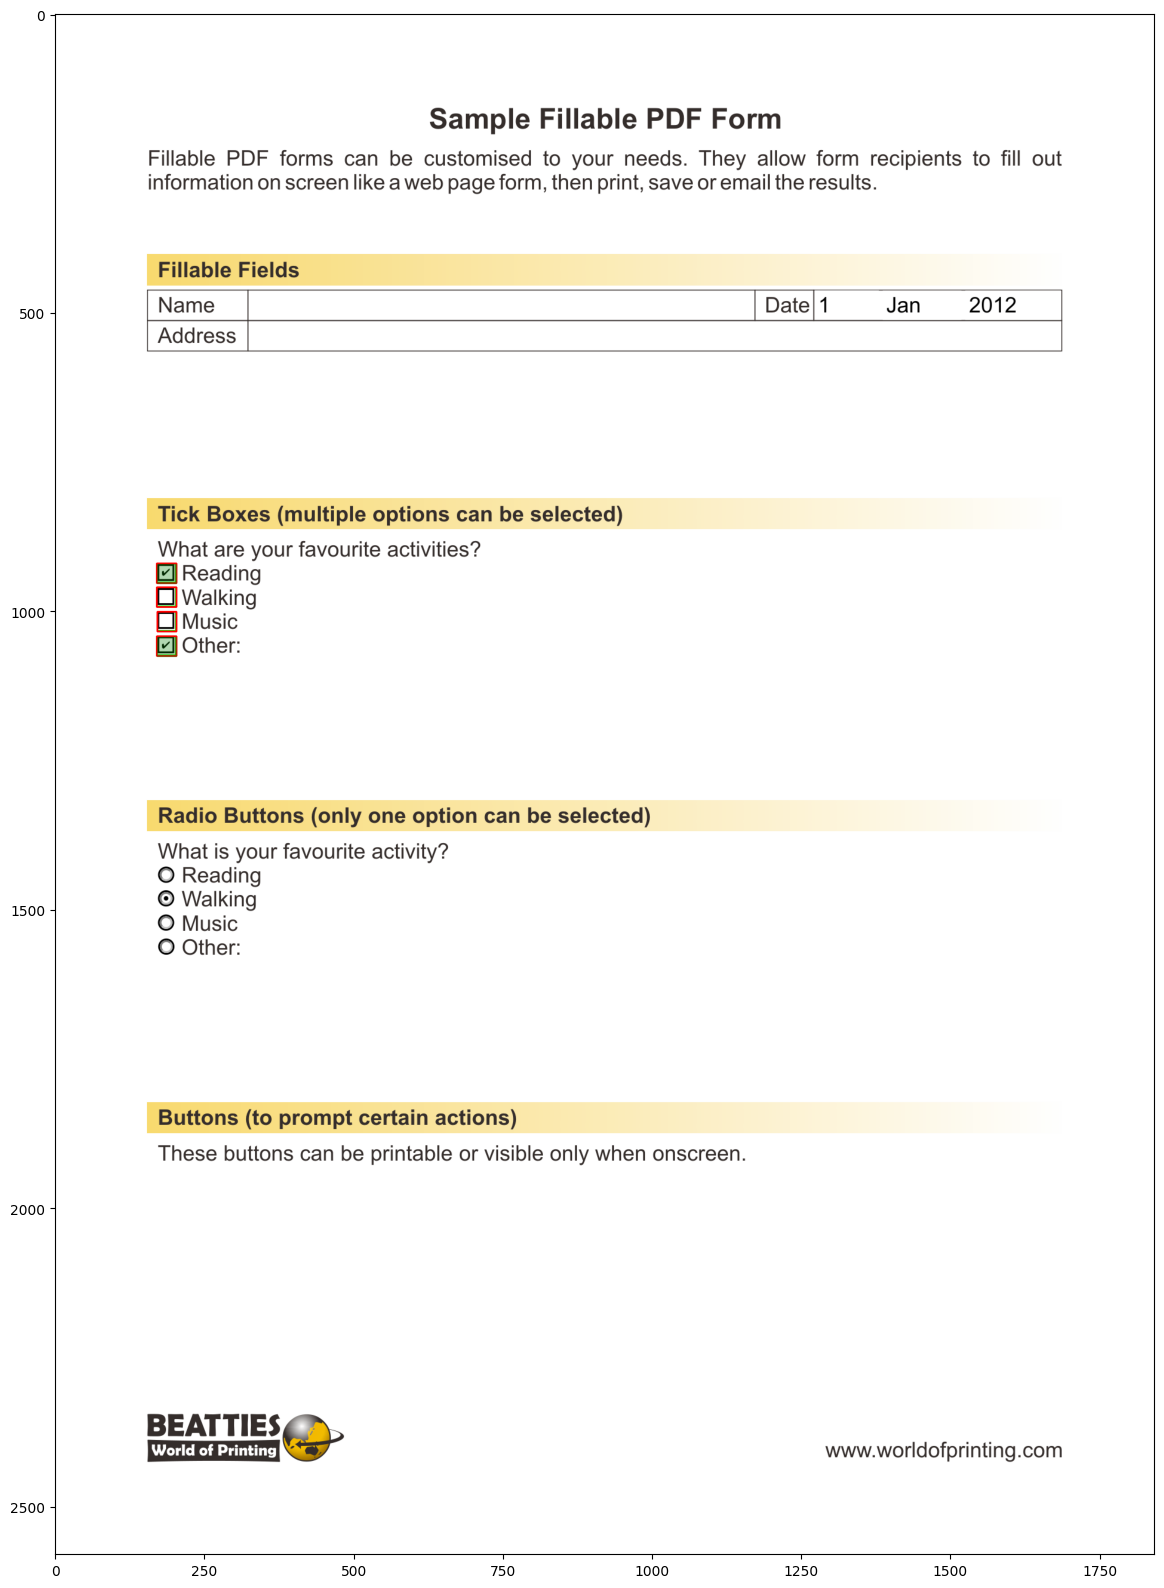

In [51]:
# Process test.pdf to find checkboxes
threshold = 0.1
zoom = 3
filename = 'test2.pdf'

# Convert pdf to png using fitz
pdffile = filename
doc = fitz.open(pdffile)
page = doc.load_page(0)
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
pix.save('test.png')

# Find checkboxes using boxdetect
file_path = 'test.png' # https://www.thewebjockeys.com/TheWebJockeys/Fillable_PDF_Sample_from_TheWebJockeys_vC5.pdf
rects, grouping_rects, image, output_image = get_boxes(
    file_path, cfg=cfg, plot=False)

# Get checkbox candidate scores
checkboxes = get_checkboxes(
    file_path, cfg=cfg, px_threshold=threshold, plot=False, verbose=True)

# Specify checkerbox scores since not included in original boxdetect package
checkbox_score = []
for i in range(len(checkboxes)):
    checkbox_score.append(np.count_nonzero(checkboxes[i, 2])/len(np.where(checkboxes[i,2]>-1)[0]))
checkboxes = np.hstack((checkboxes, np.array([checkbox_score]).reshape(-1,1)))

# Optimize if checked boxes are filled or not by assuming uniform minimum infill
minimum_score = min(checkboxes[:,3])
for i in range(len(checkboxes)):
    if checkboxes[i,3]-minimum_score>threshold:
        checkboxes[i,1]=True
    else:
        checkboxes[i,1]=False

# Only where returned marks is true
rects_checked = checkboxes[checkboxes[:,1]==True, 0]

# Plot boxes
plt.figure(figsize=(20,20))
plt.imshow(output_image)
for rectangle in rects_checked:
    rectangle = plt.Rectangle(rectangle[0:2], rectangle[2], rectangle[3], color='green', fill='green', alpha=0.3)
    plt.gca().add_patch(rectangle)
plt.show()

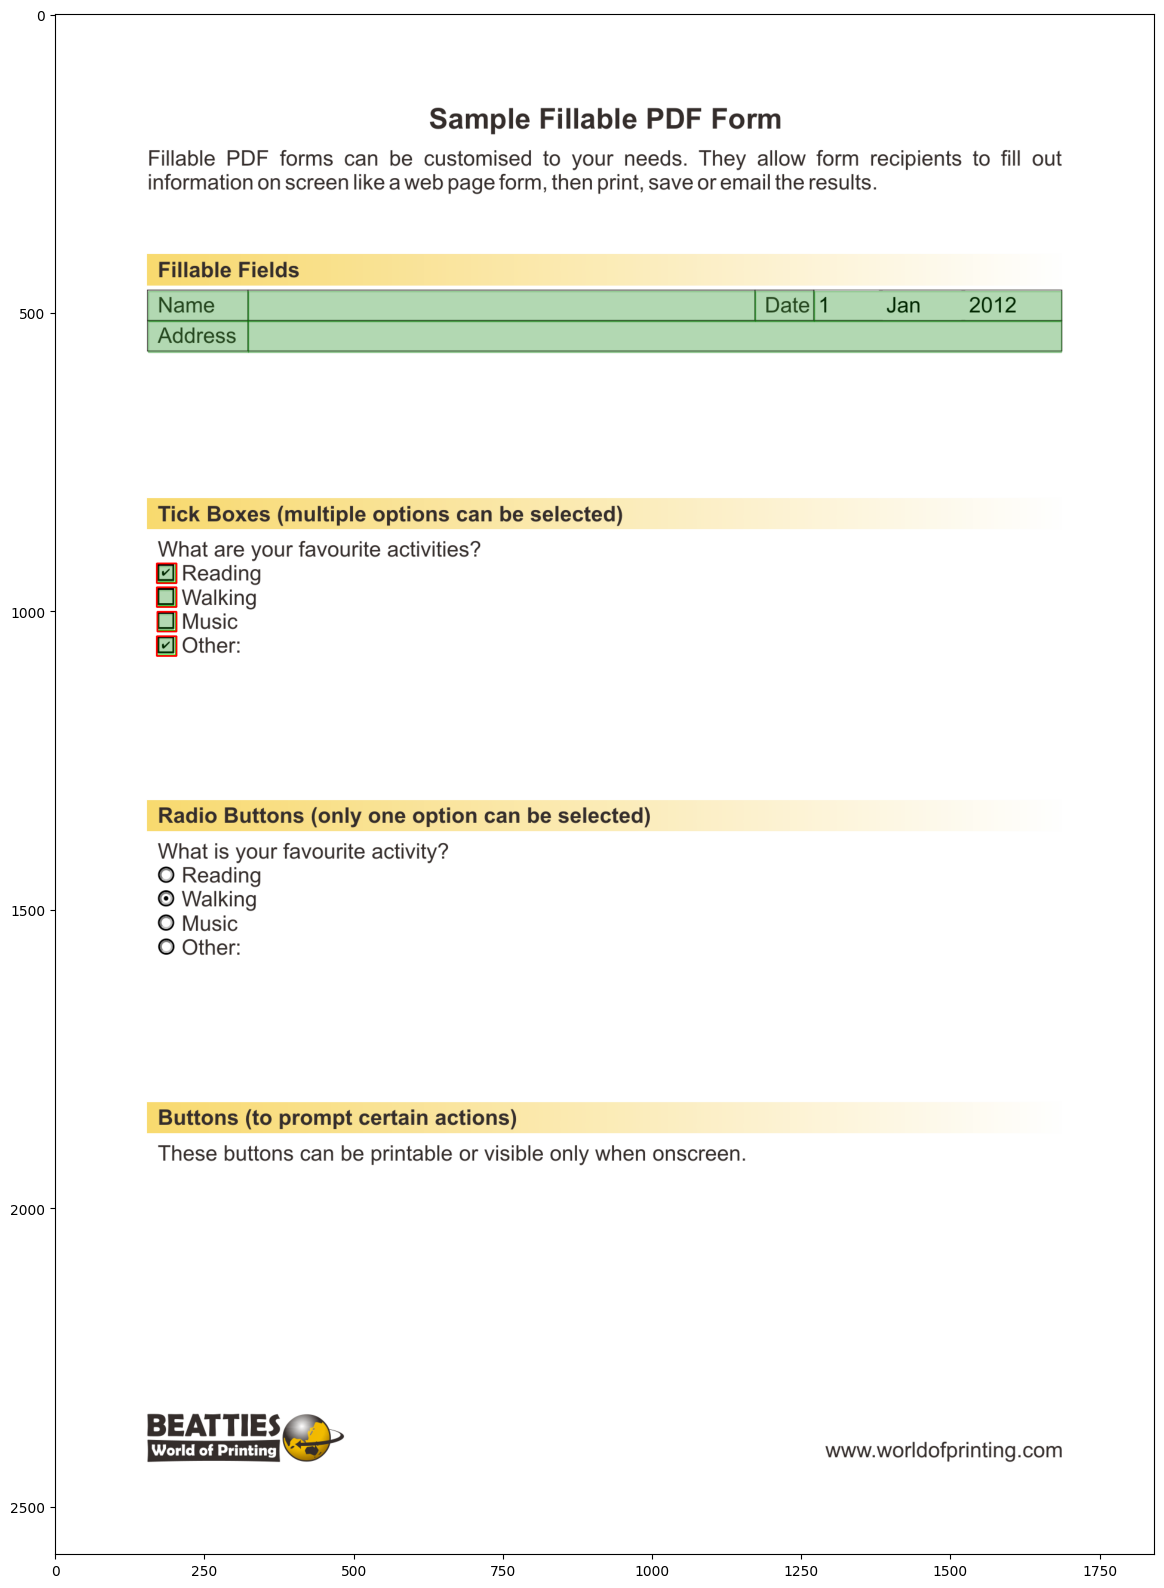

In [52]:
# Use data directly from PDF file

with pdfplumber.open(filename) as pdf:
   first_page = pdf.pages[0]
   rects = pd.DataFrame(first_page.objects['rect'])

# Plot boxes
plt.figure(figsize=(20,20))
plt.imshow(output_image)
for i in range(len(rects)):
    rectangle = rects.iloc[i, :]
    if rectangle['linewidth']>0:
      rectangle = np.array(rectangle[['x0', 'y1', 'width', 'height']])*zoom
      rectangle = plt.Rectangle((rectangle[0], first_page.mediabox[3]*zoom-rectangle[1]), rectangle[2], rectangle[3], color='green', fill='green', alpha=0.3)
      plt.gca().add_patch(rectangle)
plt.show()